1. Récupérer la donnée : train.csv ; test.csv : https://discord.com/channels/1020279842798841876/1020279843599958109/1059747069553803285
2. Entrainer les modeles : Regression lineaire, Ridge, Lasso, ElasticNet.
3. Modifier les hyperparmetres de ces models à l'aide de GridSearch et RandomizeSearch.
Utiliser ces méthodes : 
.bestscore
.bestparams
.bestestimator

4. Récupérer le .bestestimator et afficher la learning curve : https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.learning_curve.html
5. Interpreter la learning curve et conclure sur l'over, l'under ou la généralisation

In [92]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.stats.api as sms
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet, Lasso
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV, learning_curve
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn import set_config
import warnings


warnings.filterwarnings('ignore')
set_config(display="diagram")

In [48]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [49]:
df_train.sample(5)

,beds,baths,size,size_units,lot_size,lot_size_units,zip_code,price
1690,1,1.0,460.0,sqft,8094.0,sqft,98108,1250000.0
1259,4,5.5,3100.0,sqft,9450.0,sqft,98125,1375000.0
839,2,2.0,1020.0,sqft,776.0,sqft,98118,605000.0
1502,4,3.0,2050.0,sqft,4362.0,sqft,98136,920000.0
1420,4,2.0,2787.0,sqft,6011.0,sqft,98122,1207000.0


In [50]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2016 entries, 0 to 2015
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   beds            2016 non-null   int64  
 1   baths           2016 non-null   float64
 2   size            2016 non-null   float64
 3   size_units      2016 non-null   object 
 4   lot_size        1669 non-null   float64
 5   lot_size_units  1669 non-null   object 
 6   zip_code        2016 non-null   int64  
 7   price           2016 non-null   float64
dtypes: float64(4), int64(2), object(2)
memory usage: 126.1+ KB


In [51]:
df_train.nunique()

beds               11
baths              16
size              879
size_units          1
lot_size          959
lot_size_units      2
zip_code           28
price             767
dtype: int64

In [52]:
df_train.describe()

,beds,baths,size,lot_size,zip_code,price
count,2016.000000,2016.000000,2016.000000,1669.000000,2016.000000,2.016000e+03
mean,2.857639,2.159970,1735.740575,3871.059694,98123.638889,9.636252e+05
std,1.255092,1.002023,920.132591,2719.402066,22.650819,9.440954e+05
min,1.000000,0.500000,250.000000,0.230000,98101.000000,1.590000e+05
25%,2.000000,1.500000,1068.750000,1252.000000,98108.000000,6.017500e+05
50%,3.000000,2.000000,1560.000000,4000.000000,98117.000000,8.000000e+05
75%,4.000000,2.500000,2222.500000,6000.000000,98126.000000,1.105250e+06
max,15.000000,9.000000,11010.000000,9998.000000,98199.000000,2.500000e+07


In [53]:
print('train :', df_train['size_units'].unique(), '\n',
      'test :', df_test['size_units'].unique())

train : ['sqft'] 
 test : ['sqft']


In [54]:
df_train_clean = df_train.drop(columns='size_units')
df_test_clean = df_test.drop(columns='size_units')

In [55]:
print('train :', df_train['lot_size_units'].unique(), '\n',
      'test :', df_test['lot_size_units'].unique())

train : ['sqft' 'acre' nan] 
 test : ['sqft' 'acre' nan]


In [56]:
df_train_temp = pd.get_dummies(df_train_clean[['lot_size_units']])
df_train_clean['lot_size'] = df_train_temp['lot_size_units_sqft']*df_train_clean['lot_size'] + df_train_temp['lot_size_units_acre']*df_train_clean['lot_size']*43560
df_train_clean.drop(columns='lot_size_units', inplace=True)

In [57]:
df_test_temp = pd.get_dummies(df_test_clean[['lot_size_units']])
df_test_clean['lot_size'] = df_test_temp['lot_size_units_sqft']*df_test_clean['lot_size'] + df_test_temp['lot_size_units_acre']*df_test_clean['lot_size']*43560
df_test_clean.drop(columns='lot_size_units', inplace=True)

In [58]:
Q1 = df_train_clean["price"].quantile(0.25)
Q3 = df_train_clean["price"].quantile(0.75)
IQR = Q3 - Q1
df_train_clean = df_train_clean[~((df_train_clean["price"]<(Q1-1.5*IQR)) | (df_train_clean["price"] > (Q3 + 1.5*IQR)))]

In [59]:
y_train = df_train_clean[['price']]
X_train = df_train_clean.drop(columns='price')

In [60]:
y_test = df_test_clean[['price']]
X_test = df_test_clean.drop(columns='price')

In [61]:
X_train['zip_code'] = X_train['zip_code'].apply(lambda x: str(x))
X_test['zip_code'] = X_test['zip_code'].apply(lambda x: str(x))

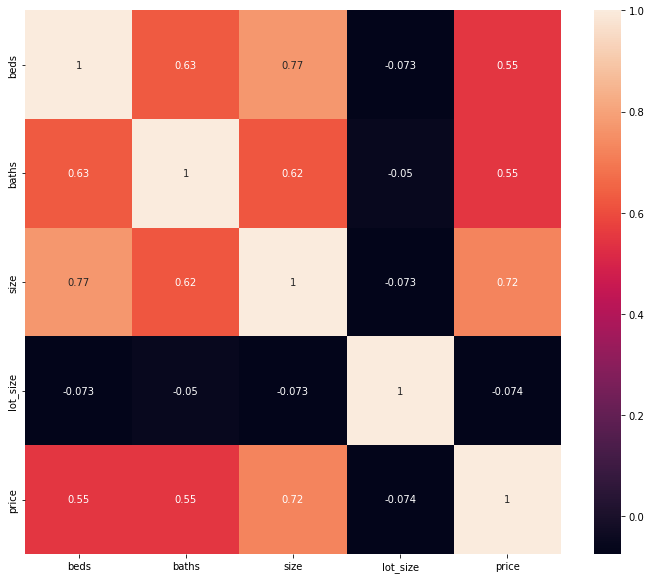

In [62]:
plt.figure(figsize=(12,10))
sns.heatmap(df_train_clean.drop(columns='zip_code').corr(), annot=True);

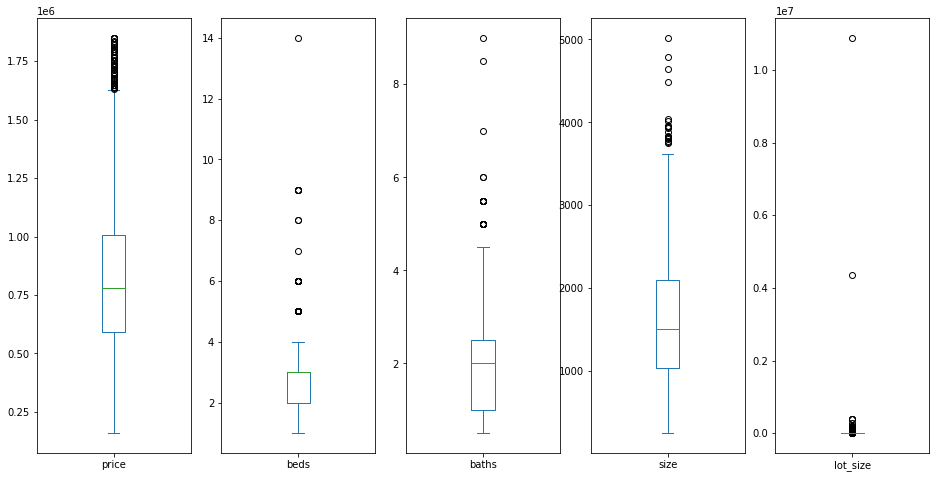

In [63]:
pd.concat([y_train, X_train.drop(columns='zip_code')], axis=1).plot(kind='box', subplots=True, figsize=(16,8));

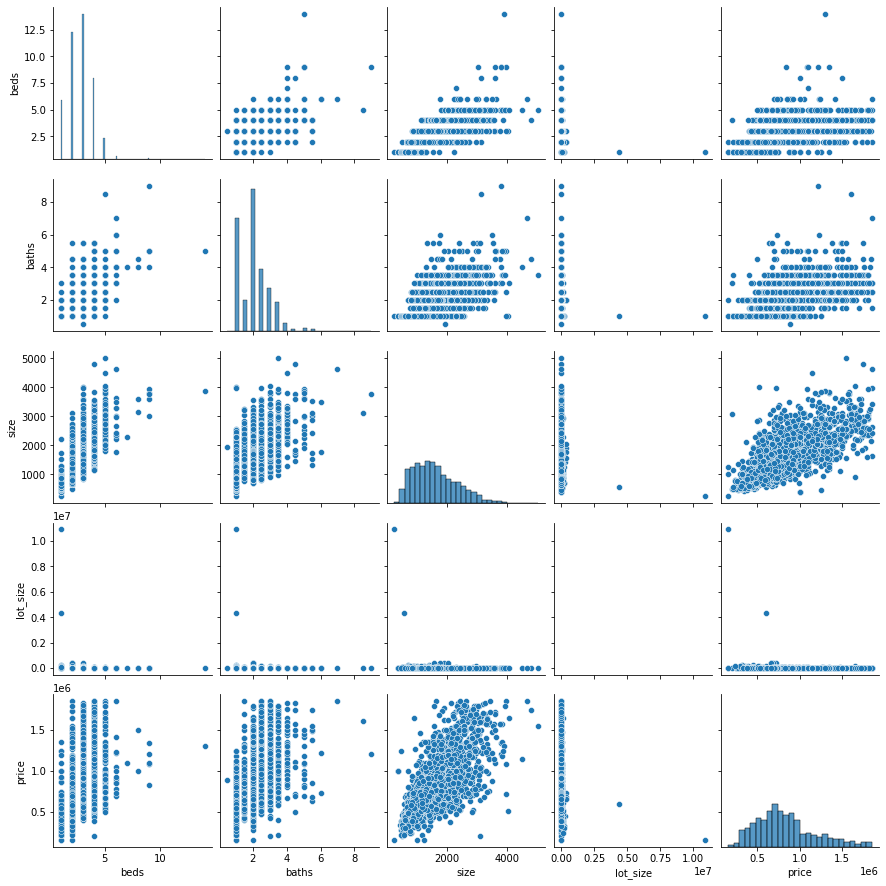

In [64]:
sns.pairplot(df_train_clean.drop(columns='zip_code'));

In [65]:
methods = [LinearRegression, Ridge, Lasso, ElasticNet]
X = X_train.drop(columns='zip_code').fillna(X_train['lot_size'].mean())
coefs = []

for method in methods:
    model = method().fit(X, y_train)
    if method.__name__ in ['LinearRegression', 'Ridge']:
        coefs.append(pd.DataFrame({f"coef {method.__name__}": pd.Series(model.coef_[0], index=X.columns)}))
    else: coefs.append(pd.DataFrame({f"coef {method.__name__}": pd.Series(model.coef_, index=X.columns)}))
    
ols = sm.OLS(y_train, sm.add_constant(X)).fit()
coefs.append(pd.DataFrame({f"p_value (%)":  pd.Series(ols.pvalues*100, index = ols.pvalues.index[1:])}))

pd.concat([coef for coef in coefs], axis=1)\
    .applymap(lambda x: int(x))\
    .style.applymap(lambda x: 'color: red' if x == 0 else 'color: white')

,coef LinearRegression,coef Ridge,coef Lasso,coef ElasticNet,p_value (%)
beds,-28088,-28037,-28085,-9371,0
baths,68943,68858,68940,32264,0
size,323,323,323,328,0
lot_size,0,0,0,0,23


In [66]:
X_train.drop(columns='lot_size', inplace=True)
X_test.drop(columns='lot_size', inplace=True)

In [67]:
num_cols = ['beds', 'baths', 'size']
cat_cols = ['zip_code']

In [68]:
num_transformer=MinMaxScaler()
cat_transformer=OneHotEncoder(handle_unknown='ignore', drop='first')

num_pipeline = Pipeline([('scaler', num_transformer)])

preprocessor = ColumnTransformer([
    ('num_transformer', num_pipeline, num_cols),
    ('cat_transformer', cat_transformer, cat_cols)])

linreg = make_pipeline(preprocessor, LinearRegression())
linreg.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num_transformer',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  ['beds', 'baths', 'size']),
                                                 ('cat_transformer',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['zip_code'])])),
                ('linearregression', LinearRegression())])

In [69]:
print('Cross validation:')
for i, r2 in enumerate(cross_val_score(linreg, X_train, y_train, cv=5, scoring='r2')):
    (R2 := np.array(r2))
    print(f' {i+1}. r2 = {round(r2,2)}')
print('Moyenne des r2 :', round(R2.mean(),2))
print('Score du test :', round(linreg.score(X_test, y_test),2))

Cross validation:
 1. r2 = 0.68
 2. r2 = 0.62
 3. r2 = 0.55
 4. r2 = 0.6
 5. r2 = 0.69
Moyenne des r2 : 0.69
Score du test : 0.54


In [70]:
param_ridge = {'alpha' : np.linspace(43, 45, 3),
               'solver' : ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga', 'lbfgs']}

grid_ridge = GridSearchCV(Ridge(), param_ridge, scoring="r2")
grid_ridge.fit(X_train, y_train)

display(grid_ridge.best_params_)
display(grid_ridge.best_score_)
display(grid_ridge.best_estimator_)

{'alpha': 45.0, 'solver': 'svd'}

0.542320107270559

Ridge(alpha=45.0, solver='svd')

In [71]:
param_lasso = {'alpha' : np.linspace(504, 506, 3),
               'selection' : ['cyclic', 'random']}

grid_lasso = GridSearchCV(Lasso(), param_lasso, scoring="r2")
grid_lasso.fit(X_train, y_train)

display(grid_lasso.best_params_)
display(grid_lasso.best_score_)
display(grid_lasso.best_estimator_)

{'alpha': 506.0, 'selection': 'random'}

0.5422660068285575

Lasso(alpha=506.0, selection='random')

In [72]:
param_elastic = {'alpha' : np.linspace(0.16, 0.17, 2), 
                 'l1_ratio' : np.linspace(0.82, 0.84, 3),
                 'selection' : ['cyclic', 'random']}

grid_elastic = GridSearchCV(ElasticNet(), param_elastic, scoring="r2")
grid_elastic.fit(X_train, y_train)

display(grid_elastic.best_params_)
display(grid_elastic.best_score_)
display(grid_elastic.best_estimator_)

{'alpha': 0.17, 'l1_ratio': 0.83, 'selection': 'random'}

0.5423202331283264

ElasticNet(alpha=0.17, l1_ratio=0.83, selection='random')

In [93]:
train_sizes, train_scores, test_scores = learning_curve(
    estimator=grid_ridge.best_estimator_,
    X=pd.concat([X_train, X_test]),
    y=pd.concat([y_train, y_test]),
    cv=5,
    scoring="r2",
    train_sizes = [10, 20, 25, 30, 35, 40, 50, 60, 75, 80, 100, 125, 150, 175, 250, 375, 500]
)

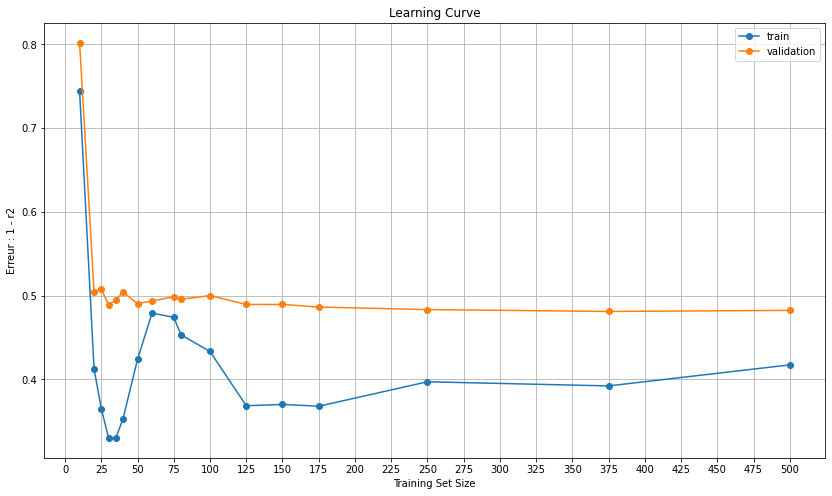

In [94]:
train_mean = 1-train_scores.mean(axis=1)
test_mean = 1-test_scores.mean(axis=1)

plt.subplots(figsize=(14,8))
plt.plot(train_sizes, train_mean, label="train", marker='o')
plt.plot(train_sizes, test_mean, label="validation", marker='o')

plt.title("Learning Curve")
plt.xlabel("Training Set Size")
plt.xticks(np.arange(0, 501, 25))
plt.ylabel("Erreur : 1 - r2")
plt.legend(loc="best")
plt.grid(True)
plt.show()